## Classification of Covid 19 tweets to assertain what can be learnt about public knowledge on symptoms, treatment and prevention of the virus

this project is an effort to contribute to health surveillance in order to help medical professionals coalate useful information to aid in intervention measures in the situation of an outbreak

The objectives of this project are:

1. implementation of bert algorithm 
2. aid in labelling large data
3. information gathering


## Data processing

### Processing literature data

In [3]:
import pandas as pd
import numpy as np

In [4]:
# load covid literature data
covid_literature_df = pd.read_csv('C:/Users/Sammy/2021/final-project/data/metadata.csv', usecols=['title','abstract','authors','doi','publish_time','pdf_json_files'])
np.random.seed()


C:\Users\Sammy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
covid_literature_df.head()

,title,doi,abstract,publish_time,authors,pdf_json_files
0,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",document_parses/pdf_json/d1aafb70c066a2068b027...
1,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",document_parses/pdf_json/6b0567729c2143a66d737...
2,Surfactant protein-D and pulmonary host defense,10.1186/rr19,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",document_parses/pdf_json/06ced00a5fc04215949aa...
3,Role of endothelin-1 in lung disease,10.1186/rr44,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",document_parses/pdf_json/348055649b6b8cf2b9a37...
4,Gene expression in epithelial cells in respons...,10.1186/rr61,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",document_parses/pdf_json/5f48792a5fa08bed9f560...


In [6]:
#missing values
missing_values = covid_literature_df.isnull().sum()
missing_values

title                216
doi               180633
abstract          115815
publish_time         220
authors            12283
pdf_json_files    274650
dtype: int64

In [7]:
#percentage of missing data
all_cells = np.product(covid_literature_df.shape)
all_missing = missing_values.sum()
percentage_missing = (all_missing/all_cells)*100
print(percentage_missing)

23.501964478366585


In [8]:
#drop duplicates and fill missing values
covid_literature_df.duplicated()
covid_literature_df.drop_duplicates(keep='first', inplace=True)
covid_literature_df.fillna('no text available', inplace = True)

In [9]:
covid_literature_df['abstract'] = (covid_literature_df['title']+ ' ' + covid_literature_df['abstract']).apply(lambda row: row.strip())

In [10]:
covid_literature_df['abstract'] = covid_literature_df['abstract'].apply(lambda row: row.replace('no text available',''))

In [11]:
#reduce the dataset to literature discussing covid specific topics
def find_covid_lit(df):
    df1 = df[df['abstract'].str.contains('ncov')]
    df2 = df[df['abstract'].str.contains('corona')]
    df3 = df[df['abstract'].str.contains('covid')]
    df4 = df[df['abstract'].str.contains('-cov-2')]
    df5 = df[df['abstract'].str.contains('cov2')]
    
    
    data =[df1,df2,df3,df4,df5]
    df = pd.concat(data)
    df=df.drop_duplicates(subset='title', keep="first")
    return df
    
df=find_covid_lit(covid_literature_df)
print (df.shape)
df.head()   

(70814, 6)


,title,doi,abstract,publish_time,authors,pdf_json_files
524,Genomic Signatures of Strain Selection and Enh...,10.1371/journal.pone.0017836,Genomic Signatures of Strain Selection and Enh...,2011-03-25,"Gibbons, Henry S.; Broomall, Stacey M.; McNew,...",document_parses/pdf_json/6cc30d377f0bd9004378e...
549,The Multifaceted Poliovirus 2A Protease: Regul...,10.1155/2011/369648,The Multifaceted Poliovirus 2A Protease: Regul...,2011-04-14,"Castelló, Alfredo; Álvarez, Enrique; Carrasco,...",document_parses/pdf_json/5bff40b0df656057c9db8...
621,Dominating Biological Networks,10.1371/journal.pone.0023016,Dominating Biological Networks Proteins are es...,2011-08-26,"Milenković, Tijana; Memišević, Vesna; Bonato, ...",document_parses/pdf_json/d0acac75cb3d2c19abfe0...
784,Both TLR2 and TRIF Contribute to Interferon-β ...,10.1371/journal.pone.0033299,Both TLR2 and TRIF Contribute to Interferon-β ...,2012-03-14,"Aubry, Camille; Corr, Sinéad C.; Wienerroither...",document_parses/pdf_json/2305cbae32a50cf992335...
884,Proteasome-Dependent Disruption of the E3 Ubiq...,10.1371/journal.ppat.1002789,Proteasome-Dependent Disruption of the E3 Ubiq...,2012-07-05,"Fehr, Anthony R.; Gualberto, Nathaniel C.; Sav...",document_parses/pdf_json/5ae7223cc6ab3437ba262...


### labeling the literature data based on terms in the abstract

In [12]:
import functools
from nltk import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

# converts terms to morphological root eg. smoked and smoking to smok
def stemmer(words):
    stemmer = PorterStemmer()
    tokens=[]
    for w in words:
        tokens.append(stemmer.stem(w))
    return tokens


def get_sentences(df1,search_terms,str1):
    df_table = pd.DataFrame(columns = ["pub_date","authors","title","excerpt",'label'])
    search_terms=stemmer(search_terms)
    for index, row in df1.iterrows():
        
        pub_sentence=''
        sentences_used=0
        
        sentences = row['abstract'].split('. ')
        
        highligts=[]
        for sentence in sentences:
            
            missing=0
            
            for word in search_terms:
                
                if word not in sentence:
                    missing=1
                    
            
            if missing==0 and len(sentence)<1000 and sentence!='':
                sentence=sentence.capitalize()
                if sentence[len(sentence)-1]!='.':
                    sentence=sentence+'.'
                pub_sentence=pub_sentence+sentence
                
        if pub_sentence!='':
            sentence=pub_sentence
            sentences_used=sentences_used+1
            authors=row["authors"].split(" ")            
            title=row["title"]                       
            to_append = [row['publish_time'],authors[0]+' et al.',title,sentence,str1]
            df_length = len(df_table)
            df_table.loc[df_length] = to_append
    return df_table


def search_dataframe(df,search_terms):   
    search_words=stemmer(search_terms)
    df1=df[functools.reduce(lambda a, b: a&b, (df['abstract'].str.contains(s) for s in search_terms))]
    return df1



C:\Users\Sammy\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [13]:
#list of labels and list of search terms per label
labels = ['transmission','treatment','symptom','health risk', 'prevention']
search=[['transmission','infection','case'],['treatment','care'],['symptom','asymptomatic'],['risk','vulnerable','affect'],['prevent','quarantine']]
label_table = ['','','','','']
q=0


for search_terms in search:
    #str1=''
    str1 = labels[q]
    
    #search the dataframe for all words
    df1=search_dataframe(df,search_terms)
   
    # get best sentences
    df_table=get_sentences(df1,search_terms,str1)    
    
    length=df_table.shape[0]

    if length<1:
        print ("No reliable data could be located in the literature")
    else:
        display(df_table.head())
    label_table[q] = df_table
    q=q+1
    
print ('done')

,pub_date,authors,title,excerpt,label
0,2020-11-20,"Boshier, et al.",Remdesivir induced viral RNA and subgenomic RN...,We conclude that these are likely to have aris...,transmission
1,2020-01-03,"Chertow, et al.","Influenza, Measles, SARS, MERS, and Smallpox",Early case identification and strict infection...,transmission
2,2020-09-17,"Gupta, et al.",Estimating the Impact of Daily Weather on the ...,"Daily maximum (t(max)), minimum (t(min)), mean...",transmission
3,2015,"Al-Tawfiq, et al.",Middle East respiratory syndrome coronavirus i...,"Data suggest the overcrowding, late recognitio...",transmission
4,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,We assessed the demographic determinants of tr...,transmission


,pub_date,authors,title,excerpt,label
0,2020-12-23,"Taylor, et al.",Awake-Prone Positioning Strategy for Non-Intub...,Five inpatient medical service teams were rand...,treatment
1,2020-06-01,"Blais, et al.",Consensus statement: summary of the Quebec Lun...,"For each level-of-activity scenario, suggestio...",treatment
2,2020,"Taylor, et al.",Awake-Prone Positioning Strategy for Non-Intub...,Five inpatient medical service teams were rand...,treatment
3,2020,"Berman, et al.",Supportive Care: An Indispensable Component of...,The current focus of cancer care is on initial...,treatment
4,2020,"Chamsi-Pasha, et al.",Ethical dilemmas in the era of COVID-19,"Across the globe, hospitals are being challeng...",treatment


,pub_date,authors,title,excerpt,label
0,2016-03-24,"Ziegler, et al.",The Lymphocytic Choriomeningitis Virus Matrix ...,The lymphocytic choriomeningitis virus matrix ...,symptom
1,2019,"Erben, et al.",Multicenter experience with endovascular treat...,Clinical presentation included asymptomatic in...,symptom
2,2020-11-20,"Badgujar, et al.",Structural insights into loss of function of a...,The opportunistic pathogen streptococcus pneum...,symptom
3,2011,"Gray, et al.",Influence of site and operator characteristics...,Methods in this assessment of the capture 2 st...,symptom
4,2016,"Brachmann, et al.",Uncovering Atrial Fibrillation Beyond Short-Te...,"However, af can be paroxysmal and asymptomatic...",symptom


,pub_date,authors,title,excerpt,label
0,2020-11-04,"Eufemia, et al.",Peacebuilding in times of COVID-19: risk-adapt...,"After reviewing academic and grey literature, ...",health risk
1,2020,"Torres-Pinzon, et al.",Coronavirus Disease 2019 and the Case to Cover...,Coronavirus disease 2019 and the case to cover...,health risk
2,2020,"Stasevic-Karlicic, et al.",Perspectives on mental health services during ...,Perspectives on mental health services during ...,health risk
3,2020,"Cattaneo, et al.",Clinical characteristics and risk factors for ...,Clinical characteristics and risk factors for ...,health risk
4,2020-04-06,"Islam, et al.",Modeling risk of infectious diseases: a case o...,Results according to the calculated risk index...,health risk


,pub_date,authors,title,excerpt,label
0,2020-09-21,"Su, et al.",Early diagnosis and population prevention of c...,Due to the lack of effective drugs and vaccine...,prevention
1,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,"In addition to case finding and isolation, tim...",prevention
2,2020-09-01,"Ayenigbara, et al.","COVID-19 (SARS-CoV-2) pandemic: fears, facts a...",The world is faced with containing the spread ...,prevention
3,2020-05-13,"Singh, et al.",Knowledge and Perception Towards Universal Saf...,Although participants' overall knowledge score...,prevention
4,2020-11-04,Feiz et al.,The health effects of quarantine during the CO...,"In the case of the coronavirus epidemic, quara...",prevention


done


In [14]:
covid_data = pd.concat([label_table[0],label_table[1],label_table[2],label_table[3],label_table[4]],axis = 0)
covid_data.reset_index()

,index,pub_date,authors,title,excerpt,label
0,0,2020-11-20,"Boshier, et al.",Remdesivir induced viral RNA and subgenomic RN...,We conclude that these are likely to have aris...,transmission
1,1,2020-01-03,"Chertow, et al.","Influenza, Measles, SARS, MERS, and Smallpox",Early case identification and strict infection...,transmission
2,2,2020-09-17,"Gupta, et al.",Estimating the Impact of Daily Weather on the ...,"Daily maximum (t(max)), minimum (t(min)), mean...",transmission
3,3,2015,"Al-Tawfiq, et al.",Middle East respiratory syndrome coronavirus i...,"Data suggest the overcrowding, late recognitio...",transmission
4,4,2020-06-17,"Jing, et al.",Household secondary attack rate of COVID-19 an...,We assessed the demographic determinants of tr...,transmission
5,5,2020-07-09,"Rockett, et al.",Revealing COVID-19 transmission in Australia b...,We report that the prospective sequencing of s...,transmission
6,6,2020-02-27,"Zhu, et al.",[Challenges and countermeasures on Chinese mal...,Due to the extensive spread and high transmiss...,transmission
7,7,2020-04-08,"Wang, et al.",Current trends and future prediction of novel ...,"Based on the current control measures, we prop...",transmission
8,8,2020-02-06,no et al.,"2019-nCoV acute respiratory disease, Australia...",It includes data on australian cases notified ...,transmission
9,9,2020-07-14,"Bahramian, et al.",COVID-19 Considerations in Pediatric Dentistry.,"Therefore, we need to beware of the symptoms a...",transmission


In [15]:
covid_data.sample(20)

,pub_date,authors,title,excerpt,label
1186,2020,"Lippi, et al.",Potential drawbacks of frequent asymptomatic c...,Potential drawbacks of frequent asymptomatic c...,symptom
1111,2020,"Romero, et al.",COVID-19 psychological impact in 3109 healthca...,The least stress respondents were asymptomatic...,symptom
135,2020,"Park, et al.",COVID-19 Outbreak and Presymptomatic Transmiss...,"We investigated the source of infection, clini...",transmission
76,2014,"Rhedin, et al.",Clinical utility of PCR for common viruses in ...,Quantitative real-time polymerase chain reacti...,symptom
184,2020-07-15,de et al.,EFFECTS OF QUARANTINE ON MENTAL HEALTH OF POPU...,Effects of quarantine on mental health of popu...,prevention
1138,2020,"Silva, et al.",Ano internacional da enfermagem e a pandemia d...,The data collection was carried out between ju...,treatment
807,2020,"Cave, et al.",Rehabilitation During a Pandemic: Psychiatrist...,We were surprised by the expectations of our p...,treatment
1133,2020,"Reza, et al.",Disruption of healthcare amid covid-19 pandemi...,Disruption of healthcare amid covid-19 pandemi...,treatment
977,2020-10-26,"Moeller, et al.",COVID-19 in children with underlying chronic r...,"Among the nine children with bpd and covid-19,...",treatment
237,2020-03-23,"Stedman, et al.",COVID-19: Modelling Local Transmission and Mor...,"To analyse case incidence, the latest values f...",transmission


In [16]:
covid_data['label'].value_counts()

symptom         2464
treatment       1149
transmission     239
prevention       189
health risk        8
Name: label, dtype: int64

In [17]:
import preprocessor as tp

In [18]:
#!pip install tweet-preprocessor

In [19]:
#remove stop words and further processing
# def stopword_remover_ex(row):
#     text = row['excerpt']
#     text = remove_stopwords(text)
#     return text   

In [20]:
# covid_data['excerpt'] = covid_data.apply(stopword_remover_ex,axis = 1)
# covid_data['excerpt'] = covid_data['excerpt'].str.lower().str.strip()

In [21]:
covid_data['excerpt']= [remove_stopwords(x) for x in covid_data['excerpt']]

### Processing tweet data

In [22]:
tweet_data = pd.read_csv('C:/Users/Sammy/OneDrive/Documents/tweets.csv')

In [23]:
print(tweet_data.head())
tweet_data.shape

                                                text         label
0  The question we need urgent answer to is how l...  transmission
1  it takes like 2 weeks for symptoms to start sh...  transmission
2  Fort Bend County has a confirmed Coronavirus p...    prevention
3  China confirms 170 deaths as coronavirus sprea...       symptom
4  Excellent discussion from @PascalJabbourMD on ...   health risk


(2000, 2)

In [24]:
tweet_data['label'].value_counts(normalize=False)

prevention      683
transmission    547
treatment       344
symptom         325
health risk      99
Name: label, dtype: int64

In [25]:
tweet_data.count()

text     2000
label    1998
dtype: int64

In [26]:
tweet_data.drop_duplicates(inplace=True)
tweet_data.dropna(inplace=True)

In [27]:
tweet_data.count()

text     1981
label    1981
dtype: int64

In [28]:
val = tweet_data.head()

### Pre-process tweets

In [29]:
def tweet_processor(row):
    
    tweet = row['text']
    tweet = tp.clean(tweet)
    
    return tweet
    

In [30]:
tweet_data['text'] = tweet_data.apply(tweet_processor,axis = 1)

In [31]:
tweet_data.head()

,text,label
0,The question we need urgent answer to is how l...,transmission
1,it takes like weeks for symptoms to start show...,transmission
2,Fort Bend County has a confirmed Coronavirus p...,prevention
3,China confirms deaths as coronavirus spreads t...,symptom
4,Excellent discussion from on cases during,health risk


In [32]:
#remove stop words and further processing
def stopword_remover(row):
    text = row['text']
    text = remove_stopwords(text)
    return text   
    

In [33]:
tweet_data['text'] = tweet_data.apply(stopword_remover,axis = 1)

In [34]:
tweet_data['text'] = tweet_data['text'].str.lower().str.strip()

In [35]:
#tweet_data['text'].str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [63]:
samp = tweet_data.sample(50)

### Joining the datasets

In [1]:
import matplotlib.pyplot as plt


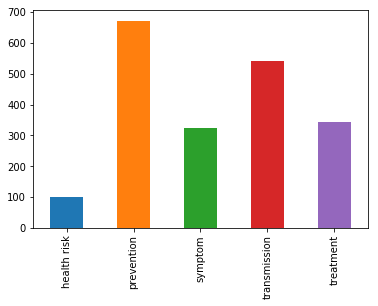

In [71]:
tweet_data['label'].value_counts().sort_index().plot.bar()

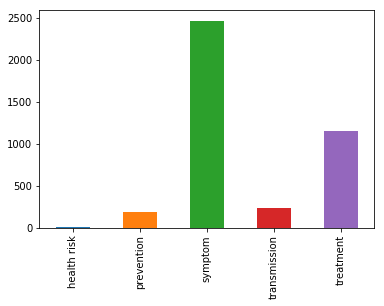

In [77]:
covid_data['label'].value_counts().sort_index().plot.bar()

###  Defining our base model

In [36]:
from sklearn.model_selection import train_test_split

In [129]:
tweet = tweet_data['text'].values
y_label = tweet_data['label'].values

In [130]:
tweet_train, tweet_test, tweet_y_train, tweet_y_test = train_test_split(tweet, y_label,test_size = 0.25, random_state = 42)

In [132]:
tweet_y_train

array(['symptom', 'prevention', 'transmission', 'transmission',
       'health risk', 'prevention', 'treatment', 'transmission',
       'treatment', 'prevention', 'transmission', 'treatment',
       'treatment', 'prevention', 'prevention', 'prevention', 'treatment',
       'treatment', 'treatment', 'symptom', 'transmission', 'treatment',
       'treatment', 'transmission', 'treatment', 'transmission',
       'transmission', 'transmission', 'transmission', 'prevention',
       'transmission', 'transmission', 'prevention', 'treatment',
       'health risk', 'transmission', 'prevention', 'prevention',
       'prevention', 'transmission', 'health risk', 'prevention',
       'prevention', 'transmission', 'transmission', 'prevention',
       'prevention', 'transmission', 'prevention', 'prevention',
       'prevention', 'transmission', 'transmission', 'transmission',
       'prevention', 'prevention', 'prevention', 'symptom', 'treatment',
       'treatment', 'prevention', 'transmission', 'tre

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizing the data

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(tweet_train)

X_train = vectorizer.transform(tweet_train)
X_test = vectorizer.transform(tweet_test)

In [45]:
len(tweet)
#X_train

983

In [46]:
# y_train = pd.factorize(tweet_y_train)
# y_test = pd.factorize(tweet_y_test)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report

#### Decision tree classifier model

In [48]:
classifier = DecisionTreeClassifier(max_depth = 10)
classifier.fit(X_train,tweet_y_train)
score = classifier.score(X_test,tweet_y_test)
print("Accuracy:", score)

predictions = classifier.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(tweet_y_test, predictions) 
print(cm)
print(classification_report(tweet_y_test, predictions))

Accuracy: 0.5487804878048781
[[ 0  0  0 11  0]
 [ 0 55  1 54  1]
 [ 0  3  0 21  1]
 [ 0  0  0 64  1]
 [ 0  1  0 17 16]]
              precision    recall  f1-score   support

 health risk       0.00      0.00      0.00        11
  prevention       0.93      0.50      0.65       111
     symptom       0.00      0.00      0.00        25
transmission       0.38      0.98      0.55        65
   treatment       0.84      0.47      0.60        34

    accuracy                           0.55       246
   macro avg       0.43      0.39      0.36       246
weighted avg       0.64      0.55      0.52       246



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic regression model

In [49]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,tweet_y_train)
lr_score = lr_classifier.score(X_test,tweet_y_test)
print("Accuracy:", lr_score)

predictions = lr_classifier.predict(X_test) 
  
# creating a confusion matrix 
lr_cm = confusion_matrix(tweet_y_test, predictions) 
print(lr_cm)
print(classification_report(tweet_y_test, predictions))

Accuracy: 0.6382113821138211
[[ 0  4  2  4  1]
 [ 0 88  1 21  1]
 [ 0  6  5 13  1]
 [ 2 15  1 47  0]
 [ 0 11  1  5 17]]
              precision    recall  f1-score   support

 health risk       0.00      0.00      0.00        11
  prevention       0.71      0.79      0.75       111
     symptom       0.50      0.20      0.29        25
transmission       0.52      0.72      0.61        65
   treatment       0.85      0.50      0.63        34

    accuracy                           0.64       246
   macro avg       0.52      0.44      0.45       246
weighted avg       0.63      0.64      0.61       246



### Base model implementation with literature as training data

In [50]:
covid_data_d = covid_data['excerpt'].values
covid_labels = covid_data['label'].values

In [51]:
#vectorizing the literature abstracts

vectorizer.fit(covid_data_d)

X_data_train = vectorizer.transform(covid_data_d)
X_test = vectorizer.transform(tweet_test)

In [53]:
classifier = DecisionTreeClassifier(max_depth = 10)
classifier.fit(X_data_train,covid_labels)
score = classifier.score(X_test,tweet_y_test)
print("Accuracy:", score)

predictions = classifier.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(tweet_y_test, predictions) 
print(cm)
print(classification_report(tweet_y_test, predictions))

Accuracy: 0.45934959349593496
[[  0  11   0   0   0]
 [  0 109   1   1   0]
 [  0  25   0   0   0]
 [  1  60   1   3   0]
 [  0  33   0   0   1]]
              precision    recall  f1-score   support

 health risk       0.00      0.00      0.00        11
  prevention       0.46      0.98      0.62       111
     symptom       0.00      0.00      0.00        25
transmission       0.75      0.05      0.09        65
   treatment       1.00      0.03      0.06        34

    accuracy                           0.46       246
   macro avg       0.44      0.21      0.15       246
weighted avg       0.54      0.46      0.31       246



In [55]:
from sklearn.preprocessing import MaxAbsScaler
norm = MaxAbsScaler ()
X_norm = norm.fit_transform(X_data_train)

lr_classifier = LogisticRegression(max_iter=200)
lr_classifier.fit(X_norm,covid_labels)
lr_score = lr_classifier.score(X_test,tweet_y_test)
print("Accuracy:", lr_score)

predictions = lr_classifier.predict(X_test) 
  
# creating a confusion matrix 
lr_cm = confusion_matrix(tweet_y_test, predictions) 
print(lr_cm)

print(classification_report(tweet_y_test, predictions))

Accuracy: 0.1991869918699187
[[ 0  0 11  0  0]
 [ 0 12 88  5  6]
 [ 0  0 24  0  1]
 [ 0  2 54  9  0]
 [ 0  2 28  0  4]]
              precision    recall  f1-score   support

 health risk       0.00      0.00      0.00        11
  prevention       0.75      0.11      0.19       111
     symptom       0.12      0.96      0.21        25
transmission       0.64      0.14      0.23        65
   treatment       0.36      0.12      0.18        34

    accuracy                           0.20       246
   macro avg       0.37      0.26      0.16       246
weighted avg       0.57      0.20      0.19       246



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Basemodel with combined data

In [135]:
# merge tweets and covid data

covid_data_copy = covid_data.copy()
covid_data_copy.rename(columns = {'excerpt':'text'},inplace=True)

tweet_df = pd.DataFrame({'text':tweet_train, 'label':tweet_y_train})

combined_data = pd.concat([covid_data_copy,tweet_df],join="inner")

In [136]:
combined_train = combined_data['text'].values
combined_y_train = combined_data['label'].values
print(combined_train[5])

We report that the prospective sequencing of sars-cov-2 clarified the probable source of infection in cases where epidemiological links could not be determined, significantly decreased the proportion of covid-19 cases with contentious links, documented genomically similar cases associated with concurrent transmission in several institutions and identified previously unsuspected links.


In [137]:
combined_data['label'].value_counts()

symptom         2545
treatment       1242
prevention       494
transmission     457
health risk       48
Name: label, dtype: int64

In [138]:
len(combined_data)

4786

In [69]:
vectorizer.fit(combined_train)

X_data_train = vectorizer.transform(combined_train)
X_test = vectorizer.transform(tweet_test)

In [70]:
classifier = DecisionTreeClassifier(max_depth = 10)
classifier.fit(X_data_train,combined_y_train)
score = classifier.score(X_test,tweet_y_test)
print("Accuracy:", score)

predictions = classifier.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(tweet_y_test, predictions) 
print(cm)
print(classification_report(tweet_y_test, predictions))

Accuracy: 0.5040650406504065
[[ 0  0  0 11  0]
 [ 0 51  1 58  1]
 [ 0  3  0 22  0]
 [ 0  2  1 62  0]
 [ 0  2  0 21 11]]
              precision    recall  f1-score   support

 health risk       0.00      0.00      0.00        11
  prevention       0.88      0.46      0.60       111
     symptom       0.00      0.00      0.00        25
transmission       0.36      0.95      0.52        65
   treatment       0.92      0.32      0.48        34

    accuracy                           0.50       246
   macro avg       0.43      0.35      0.32       246
weighted avg       0.62      0.50      0.48       246



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
from sklearn.preprocessing import MaxAbsScaler
norm = MaxAbsScaler ()
X_norm = norm.fit_transform(X_data_train)

lr_classifier = LogisticRegression(max_iter=200)
lr_classifier.fit(X_norm,combined_y_train)
lr_score = lr_classifier.score(X_test,tweet_y_test)
print("Accuracy:", lr_score)

predictions = lr_classifier.predict(X_test) 
  
# creating a confusion matrix 
lr_cm = confusion_matrix(tweet_y_test, predictions) 
print(lr_cm)

print(classification_report(tweet_y_test, predictions))

Accuracy: 0.5813008130081301
[[ 2  2  5  2  0]
 [ 0 74 11 21  5]
 [ 1  4  7 12  1]
 [ 1  3 13 47  1]
 [ 0  2  9 10 13]]
              precision    recall  f1-score   support

 health risk       0.50      0.18      0.27        11
  prevention       0.87      0.67      0.76       111
     symptom       0.16      0.28      0.20        25
transmission       0.51      0.72      0.60        65
   treatment       0.65      0.38      0.48        34

    accuracy                           0.58       246
   macro avg       0.54      0.45      0.46       246
weighted avg       0.66      0.58      0.60       246



### Implementing BERT with keras

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [42]:
#!pip install wget
#import wget

In [43]:
# url = 'https://raw.githubusercontent.com/google-research/bert/master/tokenization.py'
# filename = wget.download(url)

In [44]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(model_url, trainable=True)

INFO:absl:Using C:\Users\Sammy\AppData\Local\Temp\tfhub_modules to cache modules.


In [45]:
import tokenization

In [46]:
vocabs_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_casing = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocabs_file, do_lower_casing)

In [47]:
#sample tokens

#note the output of this 
sentence = 'By defining the three metadata tokens created from the input data. token embeddings, position embeddings and sequence embeddings'
output_text = tokenizer.tokenize(sentence)

In [48]:
print(output_text)

['by', 'defining', 'the', 'three', 'metadata', 'token', '##s', 'created', 'from', 'the', 'input', 'data', '.', 'token', 'em', '##bed', '##ding', '##s', ',', 'position', 'em', '##bed', '##ding', '##s', 'and', 'sequence', 'em', '##bed', '##ding', '##s']


In [49]:
output_text = tokenizer.convert_tokens_to_ids(output_text)
print(output_text)

[2011, 12854, 1996, 2093, 27425, 19204, 2015, 2580, 2013, 1996, 7953, 2951, 1012, 19204, 7861, 8270, 4667, 2015, 1010, 2597, 7861, 8270, 4667, 2015, 1998, 5537, 7861, 8270, 4667, 2015]


BERT uses an encoder. We define the bert_encoder function which processes the input sequence of the to the model. By defining the three metadata tokens created from the input data. token embeddings, position embeddings and sequence embeddings. we include the [CLS] token at the beginning of each sequence and [SEP] at the end of each sequence and between a pair of sequences. The maximum length of input is 512. for an input with length less than this we include 0 for padding.

In [50]:
def bert_encoder(lines, tokenizer, max_len=250):
    token_embeddings = []
    mask_embeddings = []
    segment_embeddings = []
    
    #tokenizing input sequences    
    for sentence in lines: 
        sentence = sentence.split('.')
        
        for line in sentence:
            line = tokenizer.tokenize(line)

            line = line[:max_len-2]
            input_seq = ["[CLS]"] + line + ["[SEP]"]
            pad_len = max_len - len(input_seq)

            tokens = tokenizer.convert_tokens_to_ids(input_seq) + [0] * pad_len
            pad_masks = [1] * len(input_seq) + [0] * pad_len
            segments_id = [0] * max_len

            token_embeddings.append(tokens)
            mask_embeddings.append(pad_masks)
            segment_embeddings.append(segments_id)
    
    return np.array(token_embeddings), np.array(mask_embeddings), np.array(segment_embeddings)

We build the Bert model using keras. We define the input layers, the output layers, dense and dropout layer.

In [51]:

def build_bert_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]
    layer = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(32, activation='relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    out = tf.keras.layers.Dense(5, activation='softmax')(layer)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [52]:
from collections import Counter
tweet_y_train = pd.factorize(tweet_y_train)[0]
tweet_y_test = pd.factorize(tweet_y_test)[0]
print(Counter(tweet_y_train))

Counter({1: 305, 2: 218, 4: 93, 0: 81, 3: 40})


In [88]:
max_len = 250
train_input = bert_encoder(tweet_train, tokenizer, max_len=max_len)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(tweet_y_train, num_classes=5)


In [99]:
test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [89]:
train_labels

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [90]:
model = build_bert_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

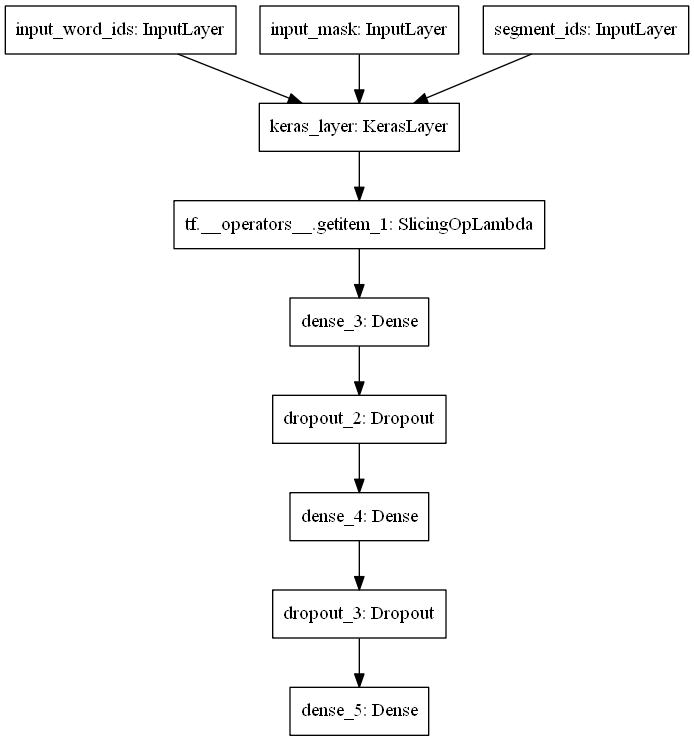

In [91]:
tf.keras.utils.plot_model(model, "my_bert_model.png")

In [92]:
#computing the class weights due to class imbalance

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(tweet_y_train),tweet_y_train)

print('class weights {}'.format(weights))

weight_dict = dict(enumerate(weights))
weight_dict


class weights [1.81975309 0.48327869 0.67614679 3.685      1.58494624]


C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 1 2 2 3 1 4 2 4 1 2 4 4 1 1 1 4 4 4 0 2 4 4 2 4 2 2 2 2 1 2 2 1 4 3 2 1
 1 1 2 3 1 1 2 2 1 1 2 1 1 1 2 2 2 1 1 1 0 4 4 1 2 4 1 0 2 1 2 3 2 1 2 2 1
 2 4 2 1 1 1 0 1 1 2 1 1 2 1 2 2 3 2 4 2 2 3 2 2 1 1 1 1 0 2 3 2 4 1 4 1 2
 1 2 1 0 3 2 1 4 0 4 1 1 1 2 1 1 1 0 2 2 2 0 3 4 1 0 2 2 1 1 1 1 1 1 1 2 4
 2 1 4 4 0 2 4 2 4 2 2 4 0 4 1 3 4 0 1 4 1 2 1 1 2 2 2 0 1 1 1 1 2 2 0 1 2
 2 2 1 1 1 2 2 2 1 2 1 1 1 2 2 4 2 1 2 3 0 0 4 1 0 4 2 4 2 1 1 4 1 2 4 2 1
 1 1 2 0 3 1 2 1 0 2 1 3 4 0 1 2 2 1 0 2 0 1 1 1 1 1 0 2 2 1 2 3 1 2 1 2 0
 1 1 4 2 1 1 4 1 1 2 0 4 2 1 0 4 0 1 1 3 3 0 1 0 1 1 0 1 1 2 3 1 1 1 0 1 2
 0 2 1 1 2 2 1 4 1 1 4 1 2 1 2 2 1 1 4 1 1 1 2 0 2 1 0 1 1 2 2 1 2 3 2 2 1
 4 4 4 1 3 1 2 2 0 1 1 2 4 1 2 2 1 2 1 1 0 4 0 1 4 1 2 4 1 2 2 2 2 2 1 4 3
 2 2 2 2 1 4 4 2 2 2 1 1 0 1 1 1 1 1 2 2 2 2 4 1 2 2 1 4 1 1 2 3 4 2 2 0 3
 1 3 0 0 1 1 2 1 1 1 1 1 1 0 0 1 2 1 3 2 4 1 1 2 1 2 4 0 

{0: 1.819753086419753,
 1: 0.48327868852459016,
 2: 0.6761467889908257,
 3: 3.685,
 4: 1.5849462365591398}

In [95]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    class_weight = weight_dict
)


Epoch 1/10
19/19 [==============================] - 1795s 95s/step - loss: 1.5813 - accuracy: 0.2954 - val_loss: 1.5875 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.58747, saving model to model.h5
Epoch 2/10
19/19 [==============================] - 1821s 96s/step - loss: 1.5527 - accuracy: 0.2750 - val_loss: 1.5304 - val_accuracy: 0.3514

Epoch 00002: val_loss improved from 1.58747 to 1.53044, saving model to model.h5
Epoch 3/10
19/19 [==============================] - 1822s 96s/step - loss: 1.5146 - accuracy: 0.3463 - val_loss: 1.5935 - val_accuracy: 0.2568

Epoch 00003: val_loss did not improve from 1.53044
Epoch 4/10
19/19 [==============================] - 1831s 97s/step - loss: 1.4283 - accuracy: 0.3277 - val_loss: 1.4243 - val_accuracy: 0.4797

Epoch 00004: val_loss improved from 1.53044 to 1.42428, saving model to model.h5
Epoch 5/10
19/19 [==============================] - 1870s 99s/step - loss: 1.3592 - accuracy: 0.4618 - val_loss: 1.4526 - val_accuracy

In [96]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)


In [106]:
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
# loss, accuracy = model.evaluate(test_input, test_labels, verbose=1)
# print("Test Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# loss, accuracy = model.evaluate(train_input, train_labels, verbose=1)
# print("Train Accuracy: {:.4f}".format(accuracy))

In [107]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.29      0.17      0.21        65
           1       0.05      0.20      0.08        25
           2       0.36      0.24      0.29       111
           3       0.14      0.03      0.05        34
           4       0.06      0.18      0.09        11

    accuracy                           0.19       246
   macro avg       0.18      0.16      0.15       246
weighted avg       0.27      0.19      0.21       246



In [108]:
print(train_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [87]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(train_history):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


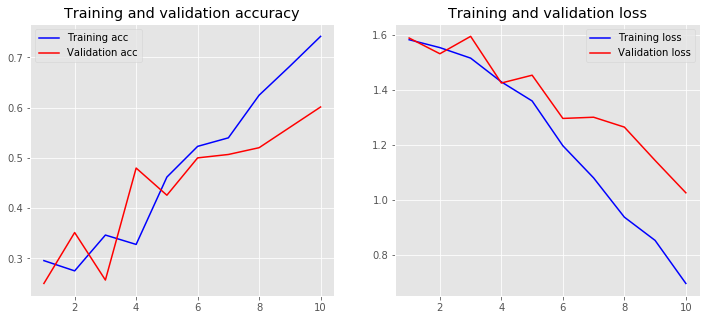

In [110]:
plot_history(train_history)

In [111]:
from tensorflow.keras.backend import clear_session
clear_session()

In [112]:
del model

### BERT implementation with literature as training data

In [66]:
text_train = covid_data['excerpt'].values
text_y_train = covid_data['label'].values

In [67]:
text_y_train = pd.factorize(text_y_train)[0]

In [68]:
#computing the class weights due to class imbalance

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(text_y_train),text_y_train)

print('class weights {}'.format(weights))

weight_dict = dict(enumerate(weights))
weight_dict


class weights [  3.38828452   0.70478677   0.3286526  101.225        4.28465608]


C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 3.388284518828452,
 1: 0.704786771105309,
 2: 0.3286525974025974,
 3: 101.225,
 4: 4.284656084656085}

In [74]:
max_len = 300
train_input = bert_encoder(text_train, tokenizer, max_len=max_len)

train_labels = tf.keras.utils.to_categorical(text_y_train, num_classes=5)


In [80]:
test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)

In [76]:
model2 = build_bert_model(bert_layer, max_len=max_len)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [78]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_1.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

train_history_lt = model2.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=15,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
#     class_weight = weight_dict
    
)

Epoch 1/15
102/102 [==============================] - 12507s 123s/step - loss: 0.6455 - accuracy: 0.7635 - val_loss: 1.3194 - val_accuracy: 0.7568

Epoch 00001: val_loss improved from inf to 1.31938, saving model to model_1.h5
Epoch 2/15
102/102 [==============================] - 13037s 128s/step - loss: 0.1553 - accuracy: 0.9691 - val_loss: 1.5870 - val_accuracy: 0.7568

Epoch 00002: val_loss did not improve from 1.31938
Epoch 3/15
102/102 [==============================] - 13071s 128s/step - loss: 0.1085 - accuracy: 0.9775 - val_loss: 1.8164 - val_accuracy: 0.7568

Epoch 00003: val_loss did not improve from 1.31938
Epoch 4/15
102/102 [==============================] - 13075s 128s/step - loss: 0.0873 - accuracy: 0.9790 - val_loss: 1.9796 - val_accuracy: 0.7543

Epoch 00004: val_loss did not improve from 1.31938
Epoch 00004: early stopping


In [81]:
model2.load_weights('model_1.h5')
test_pred = model2.predict(test_input)

In [62]:
# loss, accuracy = model2.evaluate(train_input, train_labels, verbose=1)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model2.evaluate(test_input, test_pred, verbose=1)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

3/3 [==============================] - 18s 6s/step - loss: 0.6657 - accuracy: 1.0000
Testing Accuracy:  1.0000


In [82]:
test_pred = np.argmax(test_pred, axis=1)


In [84]:
test_labels = np.argmax(test_labels, axis=1)

In [85]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.63      0.29      0.40        65
           1       0.10      0.84      0.18        25
           2       0.20      0.01      0.02       111
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        11

    accuracy                           0.17       246
   macro avg       0.19      0.23      0.12       246
weighted avg       0.27      0.17      0.13       246



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


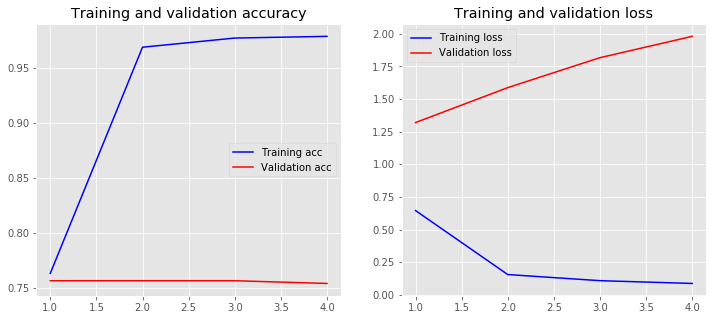

In [88]:
import matplotlib.pyplot as plt
plot_history(train_history_lt)

In [99]:
from tensorflow.keras.backend import clear_session
clear_session()

In [113]:
combineddata_train = pd.DataFrame({'text':combined_train, 'label':combined_y_train})
combineddata_train.head()

,text,label
0,We conclude likely arisen within-host evolutio...,transmission
1,Early case identification strict infection con...,transmission
2,"Daily maximum (t(max)), minimum (t(min)), mean...",transmission
3,"Data suggest overcrowding, late recognition me...",transmission
4,We assessed demographic determinants transmiss...,transmission


In [114]:
len(combineddata_train)

4786

In [124]:
combineddata_train['label'].value_counts(normalize=False)

symptom         2464
treatment       1149
1                305
transmission     239
2                218
prevention       189
4                 93
0                 81
3                 40
health risk        8
Name: label, dtype: int64

### BERT implementation with literature and tweets as training data

In [139]:
text_train = combined_data['text'].values
text_y_train = combined_data['label'].values 

In [140]:
text_y_train = pd.factorize(text_y_train)[0]

In [143]:
tweet_y_test = pd.factorize(tweet_y_test)[0]

In [141]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(text_y_train),text_y_train)

print('class weights {}'.format(weights))

weight_dict = dict(enumerate(weights))
weight_dict

class weights [ 2.09452954  0.77069243  0.37611002 19.94166667  1.93765182]


C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 2.0945295404814006,
 1: 0.7706924315619967,
 2: 0.3761100196463654,
 3: 19.941666666666666,
 4: 1.9376518218623482}

In [145]:
max_len = 300
train_input = bert_encoder(text_train, tokenizer, max_len=max_len)
test_input = bert_encoder(tweet_test, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(text_y_train, num_classes=5)


In [146]:
test_labels = tf.keras.utils.to_categorical(tweet_y_test, num_classes=5)

In [147]:
model3 = build_bert_model(bert_layer, max_len=max_len)
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [148]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_history_cb = model3.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    class_weight = weight_dict
    
)

Epoch 1/10
120/120 [==============================] - 15404s 128s/step - loss: 0.4189 - accuracy: 0.8589 - val_loss: 4.6385 - val_accuracy: 0.1754

Epoch 00001: val_accuracy improved from -inf to 0.17537, saving model to model_2.h5
Epoch 2/10
120/120 [==============================] - 15634s 130s/step - loss: 0.1179 - accuracy: 0.9703 - val_loss: 5.3728 - val_accuracy: 0.1701

Epoch 00002: val_accuracy did not improve from 0.17537
Epoch 3/10
120/120 [==============================] - 15670s 131s/step - loss: 0.0832 - accuracy: 0.9776 - val_loss: 5.4672 - val_accuracy: 0.1733

Epoch 00003: val_accuracy did not improve from 0.17537
Epoch 4/10
120/120 [==============================] - 15828s 132s/step - loss: 0.0770 - accuracy: 0.9762 - val_loss: 5.8264 - val_accuracy: 0.1785

Epoch 00004: val_accuracy improved from 0.17537 to 0.17850, saving model to model_2.h5
Epoch 5/10
120/120 [==============================] - 15699s 131s/step - loss: 0.0567 - accuracy: 0.9857 - val_loss: 5.4428 - v

In [149]:
model3.load_weights('model_2.h5')
test_pred = model3.predict(test_input)

In [150]:
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [151]:
# loss, accuracy = model2.evaluate(train_input, train_labels, verbose=1)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model2.evaluate(test_input, test_pred, verbose=1)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

In [152]:
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.61      0.42      0.50        65
           1       0.10      0.80      0.18        25
           2       0.33      0.01      0.02       111
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        11

    accuracy                           0.20       246
   macro avg       0.21      0.24      0.14       246
weighted avg       0.32      0.20      0.16       246



C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sammy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


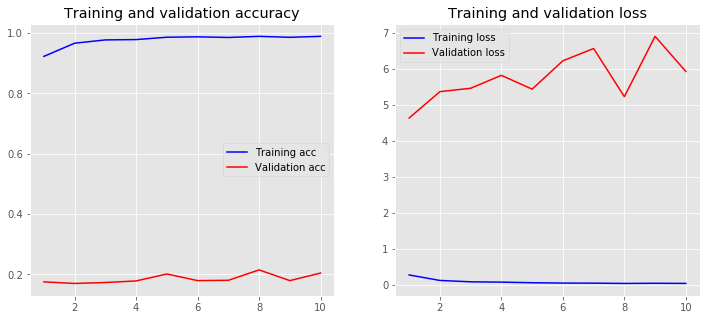

In [153]:
plot_history(train_history_cb)